## data
https://www.kaggle.com/datasets/pythonafroz/electrical-motor-operational-state-sound-data/code

In [1]:
import os
import glob
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
from IPython import display
import torchaudio
from torch.utils.data import Dataset, DataLoader

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

import warnings
warnings.filterwarnings("ignore")

FRAME_LENGTH = 255
FRAME_STEP = 128
BATCH_SIZE = 32
OUTPUT_SEQUENCE_LENGTH = 16000
TRAIN_DATASET = '/home/rickychen/桌面/voice/data/IDMT-ISA-ELECTRIC-ENGINE/test_cut/'
VALIDATION_DATASET = '/home/rickychen/桌面/voice/data/IDMT-ISA-ELECTRIC-ENGINE/train_cut'

# **Converting audio samples into spectograms**

In [2]:
class Spectrogram():
    def __init__(self):
        pass
    
    def get_spectrogram(self, waveform):
        if not isinstance(waveform, torch.Tensor):
            waveform = torch.from_numpy(waveform).float()
        

        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0)
        

        spectrogram = torch.stft(
            waveform, 
            n_fft=FRAME_LENGTH, 
            hop_length=FRAME_STEP, 
            return_complex=True
        )
        

        spectrogram = torch.abs(spectrogram)
        spectrogram = spectrogram.unsqueeze(-1)
        
        return spectrogram

    def plot_spectrogram(self, spectrogram, ax):
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.detach().cpu().numpy()
        

        if spectrogram.ndim == 4:
            spectrogram = np.squeeze(spectrogram, axis=(0, -1))
        elif spectrogram.ndim == 3:
            spectrogram = np.squeeze(spectrogram, axis=-1)
        elif spectrogram.ndim != 2:
            raise ValueError(f"Unexpected spectrogram shape: {spectrogram.shape}")
        
        log_spec = np.log(spectrogram.T + np.finfo(float).eps)
        height, width = log_spec.shape
        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
        Y = range(height)
        ax.pcolormesh(X, Y, log_spec)

In [3]:
class AudioDataset(Dataset):
    def __init__(self, root_dir, output_sequence_length):
        self.root_dir = root_dir
        self.output_sequence_length = output_sequence_length
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.files = self._get_files()

    def _get_files(self):
        files = []
        for cls_name in self.classes:
            class_dir = os.path.join(self.root_dir, cls_name)
            for filename in os.listdir(class_dir):
                if filename.endswith('.wav'):
                    files.append((os.path.join(class_dir, filename), self.class_to_idx[cls_name]))
        return files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        
        if waveform.shape[1] < self.output_sequence_length:
            waveform = torch.nn.functional.pad(waveform, (0, self.output_sequence_length - waveform.shape[1]))
        else:
            waveform = waveform[:, :self.output_sequence_length]
        
        return waveform.squeeze(), label

class AudioDataLoader():
    def __init__(self):
        pass

    def get_training_dataset_and_class_names(self):
        train_dataset = AudioDataset(TRAIN_DATASET, OUTPUT_SEQUENCE_LENGTH)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        return train_loader, train_dataset.classes

    def get_validation_and_test_datasets(self):
        full_val_dataset = AudioDataset(VALIDATION_DATASET, OUTPUT_SEQUENCE_LENGTH)
        total_size = len(full_val_dataset)
        val_size = total_size // 2
        test_size = total_size - val_size
        val_dataset, test_dataset = torch.utils.data.random_split(full_val_dataset, [val_size, test_size])
        
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        return val_loader, test_loader

In [4]:
audio_loader = AudioDataLoader()
train_loader, class_names = audio_loader.get_training_dataset_and_class_names()
print(class_names)

['engine1_good', 'engine2_broken', 'engine3_heavyload']


In [5]:
for waveforms, labels in iter(train_loader):
    print(waveforms.shape)
    print(labels.shape)
    break

torch.Size([32, 16000])
torch.Size([32])


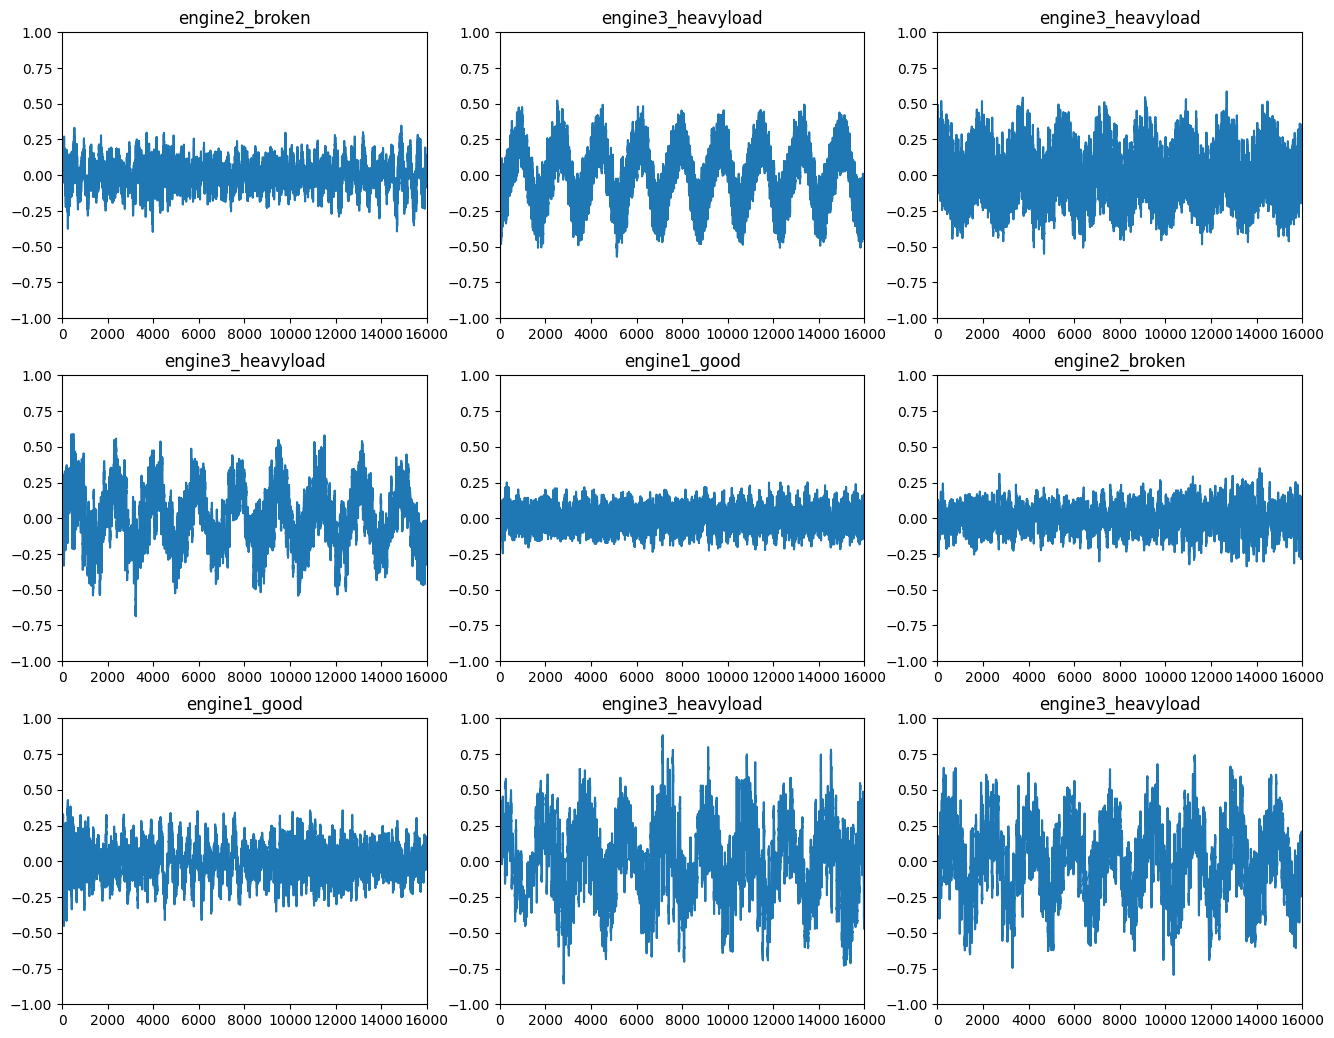

In [6]:
# 搞一批數來畫圖ㄏ
for waveforms, labels in iter(train_loader):
    break


plt.figure(figsize=(16,9))
plt.subplots_adjust(bottom=-0.2)
for i in range(min(9, len(waveforms))):
    plt.subplot(3, 3, i+1)
    plt.plot(waveforms[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis([0, OUTPUT_SEQUENCE_LENGTH, -1, 1])
plt.show()

# **從波形產生時譜圖**

In [7]:
spec = Spectrogram()

In [8]:
for j in range(6):
    label = class_names[labels[j]]
    waveform = waveforms[j]
    spectrogram = spec.get_spectrogram(waveform)
    print(f"\nLabel: {label}")
    print(f"Spectrogram Shape: {spectrogram.shape}\n")
    display.display(display.Audio(waveform.numpy(), rate=16000))


Label: engine2_broken
Spectrogram Shape: torch.Size([1, 128, 125, 1])




Label: engine3_heavyload
Spectrogram Shape: torch.Size([1, 128, 125, 1])




Label: engine3_heavyload
Spectrogram Shape: torch.Size([1, 128, 125, 1])




Label: engine3_heavyload
Spectrogram Shape: torch.Size([1, 128, 125, 1])




Label: engine1_good
Spectrogram Shape: torch.Size([1, 128, 125, 1])




Label: engine2_broken
Spectrogram Shape: torch.Size([1, 128, 125, 1])



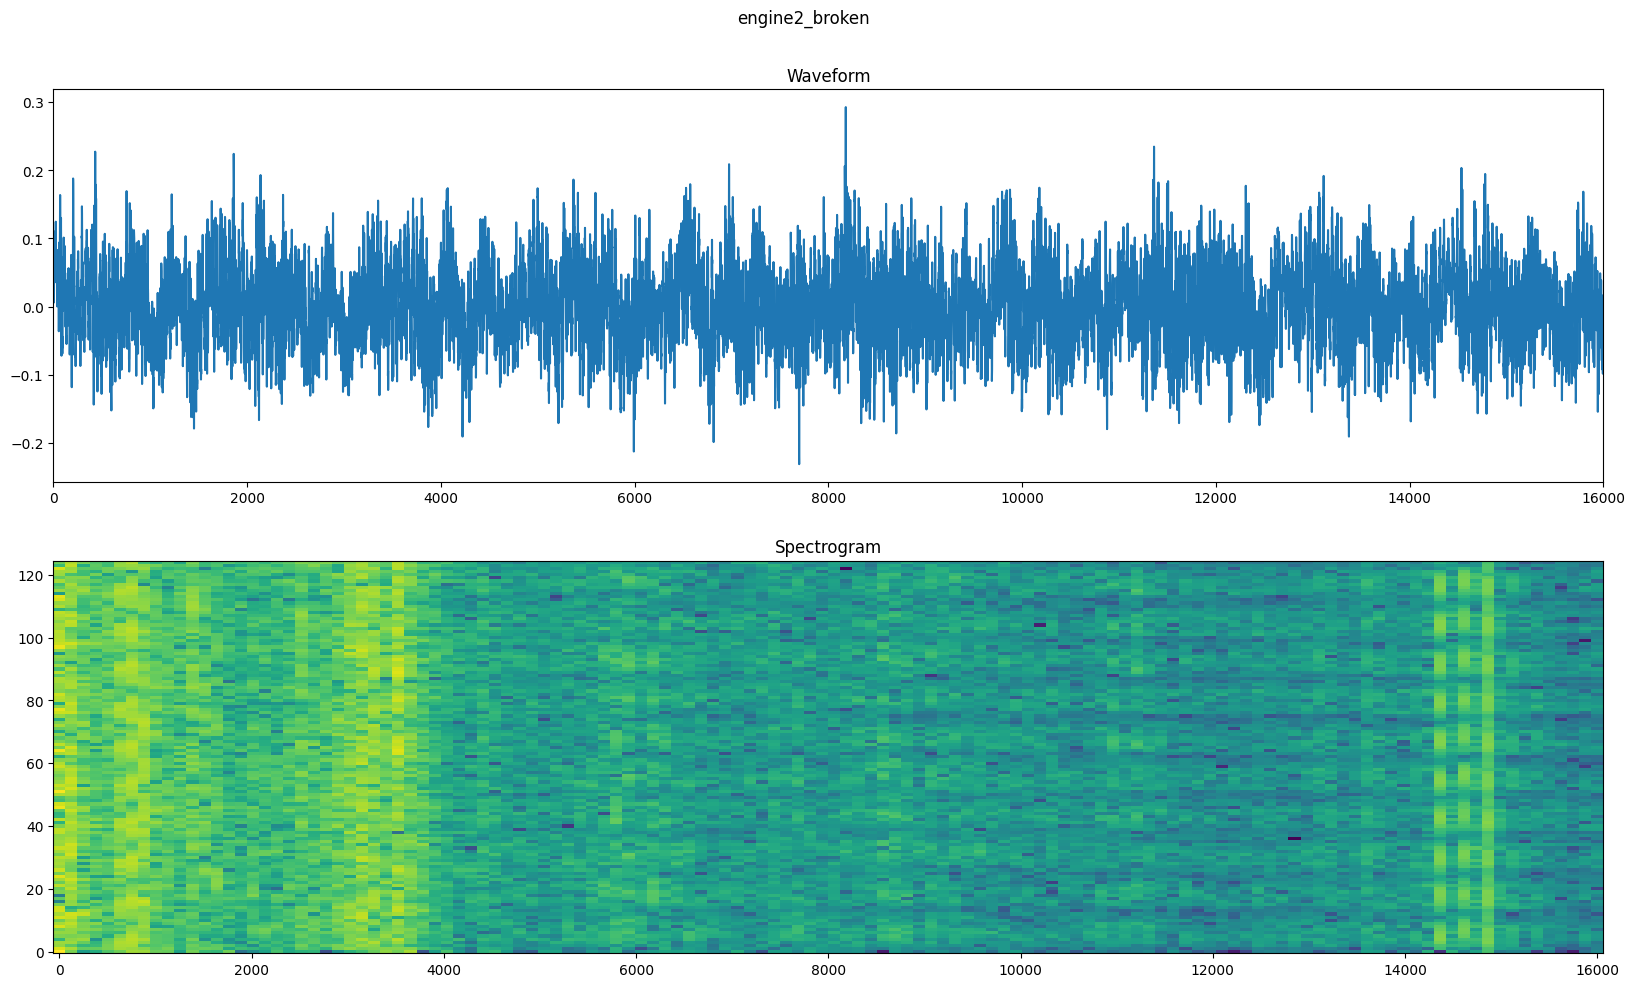

In [9]:
audio_loader = AudioDataLoader()
train_loader, class_names = audio_loader.get_training_dataset_and_class_names()


for waveform, label in iter(train_loader):
    break

waveform = waveform[0]
label = label[0]
spec = Spectrogram()
spectrogram = spec.get_spectrogram(waveform)


fig, axes = plt.subplots(2, figsize=(20, 8))
plt.subplots_adjust(bottom=-0.2)


timescale = torch.arange(waveform.shape[0])
axes[0].plot(timescale.numpy(), waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, OUTPUT_SEQUENCE_LENGTH])


spec.plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('Spectrogram')


plt.suptitle(class_names[label])

plt.show()

# **CNN**

In [10]:
from torch.utils.data import Dataset, DataLoader

class SpectrogramDataset(Dataset):
    def __init__(self, audio_dataset, spectrogram_func):
        self.audio_dataset = audio_dataset
        self.spectrogram_func = spectrogram_func
    
    def __len__(self):
        return len(self.audio_dataset)
    
    def __getitem__(self, idx):
        audio, label = self.audio_dataset[idx]
        spectrogram = self.spectrogram_func(audio)
        return spectrogram, label


audio_loader = AudioDataLoader()
train_loader, class_names = audio_loader.get_training_dataset_and_class_names()
val_loader, test_loader = audio_loader.get_validation_and_test_datasets()
spec = Spectrogram()


train_spectrogram_ds = SpectrogramDataset(train_loader.dataset, spec.get_spectrogram)
validation_spectrogram_ds = SpectrogramDataset(val_loader.dataset, spec.get_spectrogram)
test_spectrogram_ds = SpectrogramDataset(test_loader.dataset, spec.get_spectrogram)


BATCH_SIZE = 32  
train_spectrogram_loader = DataLoader(train_spectrogram_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_spectrogram_loader = DataLoader(validation_spectrogram_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_spectrogram_loader = DataLoader(test_spectrogram_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


print(f"Training dataset size: {len(train_spectrogram_ds)}")
print(f"Validation dataset size: {len(validation_spectrogram_ds)}")
print(f"Test dataset size: {len(test_spectrogram_ds)}")

Training dataset size: 2021
Validation dataset size: 178
Test dataset size: 179


In [11]:
for example_spectrograms, example_labels in iter(train_spectrogram_loader):
    break

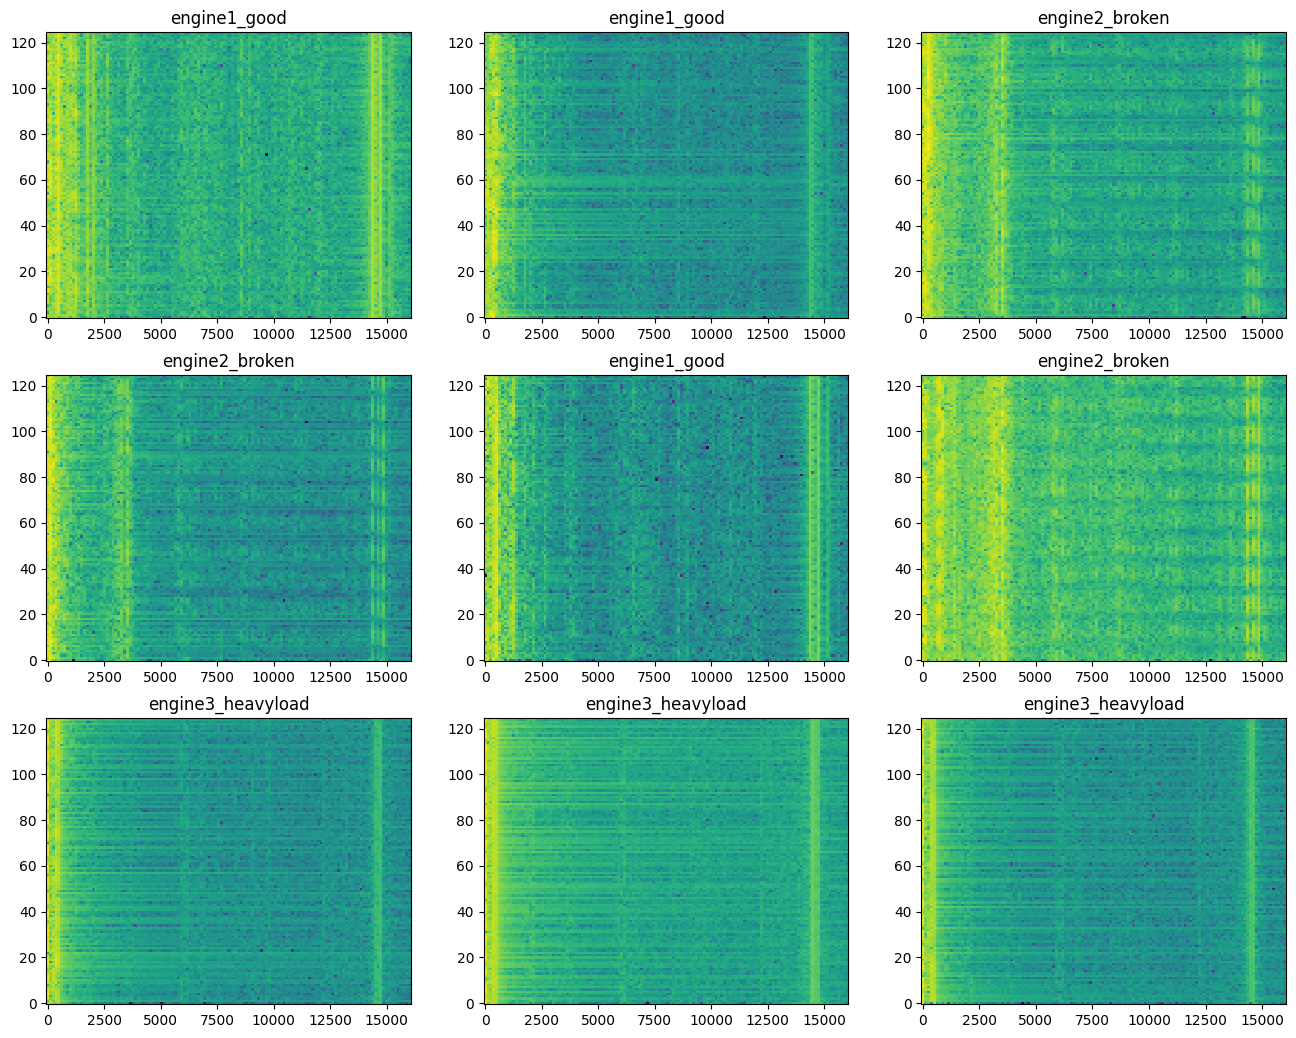

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
plt.subplots_adjust(bottom=-0.2)
for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    spec.plot_spectrogram(example_spectrograms[i].squeeze().numpy(), ax)
    ax.set_title(class_names[example_labels[i].item()])
plt.show()

In [13]:
train_spectrogram_loader = DataLoader(train_spectrogram_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
validation_spectrogram_loader = DataLoader(validation_spectrogram_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_spectrogram_loader = DataLoader(test_spectrogram_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# **Create the CNN Model**

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class AudioClassifier(nn.Module):
    def __init__(self, input_shape, num_labels):
        super().__init__()
        self.input_shape = input_shape
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 32 * 31, 128)  
        self.fc2 = nn.Linear(128, num_labels)

    def forward(self, x):
        if x.dim() == 4:  # [batch, height, width, channel]
            x = x.permute(0, 3, 1, 2)  # 變為 [batch, channel, height, width]
        elif x.dim() == 3:  # [height, width, channel]
            x = x.permute(2, 0, 1).unsqueeze(0)  # 變為 [1, channel, height, width]
        elif x.dim() == 5:  # [batch, 1, height, width, channel]
            x = x.squeeze(1).permute(0, 3, 1, 2)  # 變為 [batch, channel, height, width]
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout2(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


input_shape = (128, 125, 1)  
num_labels = len(class_names)  


model = AudioClassifier(input_shape, num_labels)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


print(model)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

print("Model, loss function, and optimizer have been set up.")

AudioClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=126976, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)
Model, loss function, and optimizer have been set up.


In [15]:
import os
from tqdm import tqdm

EPOCHS = 100
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}


if not os.path.exists('models'):
    os.makedirs('models')


pbar = tqdm(range(EPOCHS), desc="Training Progress")

for epoch in pbar:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_spectrogram_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_spectrogram_loader)
    train_acc = 100. * correct / total
    

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in validation_spectrogram_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(validation_spectrogram_loader)
    val_acc = 100. * val_correct / val_total
    
    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    

    pbar.set_description(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


torch.save(model.state_dict(), 'models/audio_classifier.pth')
print("Model saved to models/audio_classifier.pth")


import json
with open('models/training_history.json', 'w') as f:
    json.dump(history, f)
print("Training history saved to models/training_history.json")

Epoch 100/100, Loss: 0.0000, Acc: 100.00%, Val Loss: 0.0000, Val Acc: 100.00%: 100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]

Model saved to models/audio_classifier.pth
Training history saved to models/training_history.json


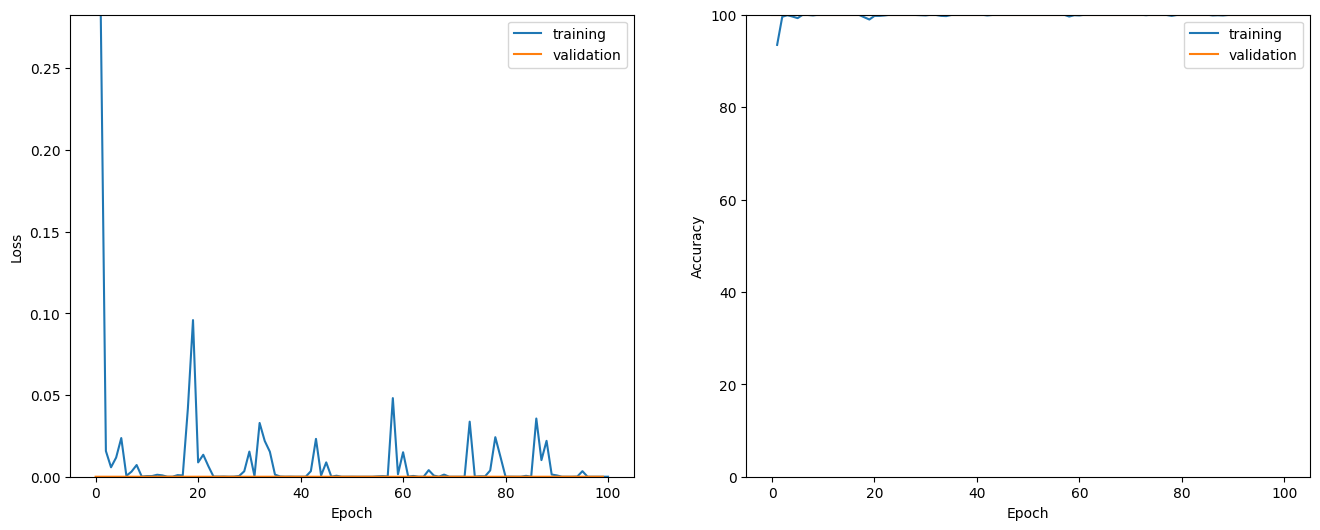

In [16]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), history['loss'], history['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(max(history['loss']), max(history['val_loss']))])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), history['accuracy'], history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 100])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

Test Loss: 0.0000, Test Acc: 100.00%


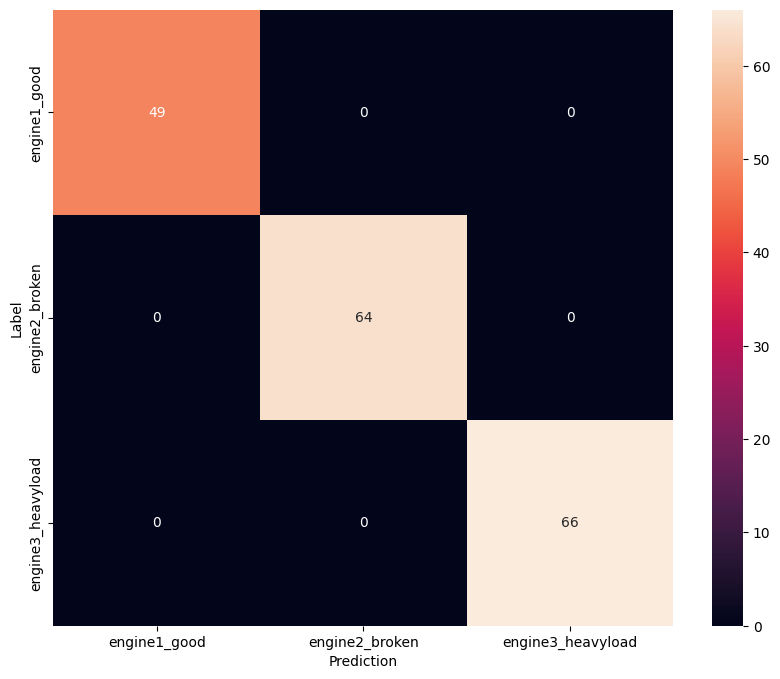

In [17]:
# 模型評估
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_spectrogram_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_spectrogram_loader)
test_acc = 100. * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


y_pred = np.array(all_preds)


y_true = np.array(all_labels)




confusion_mtx = torch.zeros(num_labels, num_labels, dtype=torch.int64)
for t, p in zip(y_true, y_pred):
    confusion_mtx[t, p] += 1

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx.numpy(),
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# **Test the Model on a Completely New Audio File**

In [18]:
x = spec.get_spectrogram(waveform)
print(f"Spectrogram shape: {x.shape}")

Spectrogram shape: torch.Size([1, 128, 125, 1])


Spectrogram shape: torch.Size([1, 128, 125, 1])


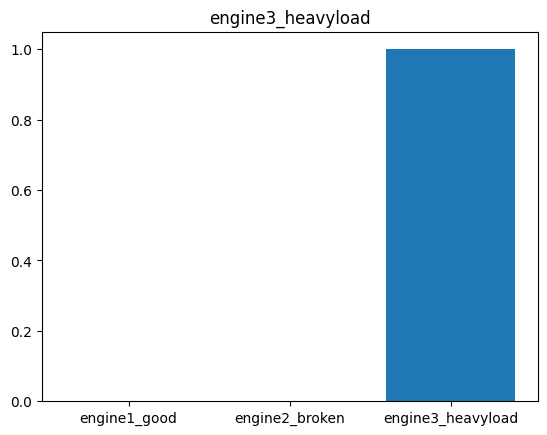

In [19]:
import torchaudio
import torch.nn.functional as F

x = '/home/rickychen/桌面/voice/data/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine3_heavyload/atmo_high_0.wav'
waveform, sample_rate = torchaudio.load(x)
waveform = waveform.squeeze() 


if waveform.size(0) < 16000:
    waveform = F.pad(waveform, (0, 16000 - waveform.size(0)))
else:
    waveform = waveform[:16000]

x = spec.get_spectrogram(waveform)
print(f"Spectrogram shape: {x.shape}")

model.eval()
with torch.no_grad():
    prediction = model(x.to(device))  

x_labels = ['engine1_good', 'engine2_broken', 'engine3_heavyload']
plt.bar(x_labels, F.softmax(prediction[0], dim=0).cpu().numpy())
plt.title('engine3_heavyload')
plt.show()

display.display(display.Audio(waveform.numpy(), rate=16000))

Spectrogram shape: torch.Size([1, 128, 125, 1])


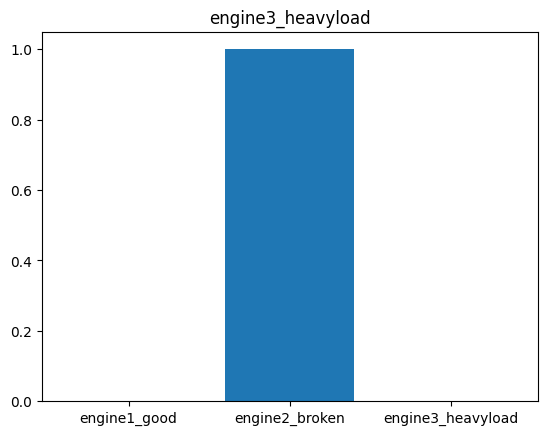

In [20]:
import torchaudio
import torch.nn.functional as F

x = '/home/rickychen/桌面/voice/data/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine2_broken/atmo_high_10.wav'
waveform, sample_rate = torchaudio.load(x)
waveform = waveform.squeeze()  


if waveform.size(0) < 16000:
    waveform = F.pad(waveform, (0, 16000 - waveform.size(0)))
else:
    waveform = waveform[:16000]

x = spec.get_spectrogram(waveform)
print(f"Spectrogram shape: {x.shape}")

model.eval()
with torch.no_grad():
    prediction = model(x.to(device)) 

x_labels = ['engine1_good', 'engine2_broken', 'engine3_heavyload']
plt.bar(x_labels, F.softmax(prediction[0], dim=0).cpu().numpy())
plt.title('engine3_heavyload')
plt.show()

display.display(display.Audio(waveform.numpy(), rate=16000))

Spectrogram shape: torch.Size([1, 128, 125, 1])


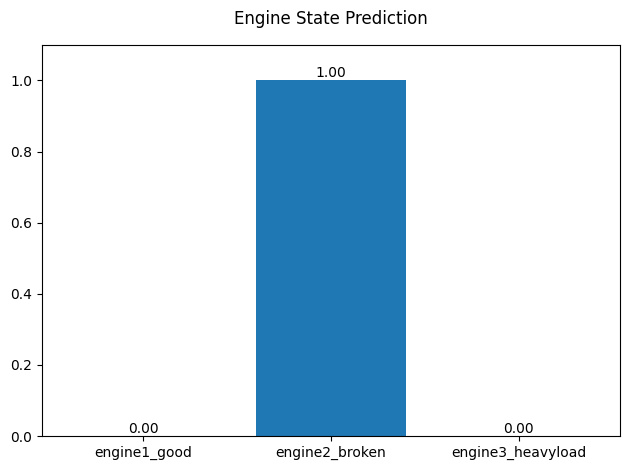

Predicted class: engine2_broken
Prediction probabilities: [0. 1. 0.]


In [25]:
model = AudioClassifier(input_shape=(128, 125, 1), num_labels=3)
model.load_state_dict(torch.load('models/audio_classifier.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

x = '/home/rickychen/桌面/voice/data/IDMT-ISA-ELECTRIC-ENGINE/test_cut/engine2_broken/atmo_high_10.wav'
waveform, sample_rate = torchaudio.load(x)
waveform = waveform.squeeze()  
if waveform.size(0) < 16000:
    waveform = F.pad(waveform, (0, 16000 - waveform.size(0)))
else:
    waveform = waveform[:16000]

x = spec.get_spectrogram(waveform)
print(f"Spectrogram shape: {x.shape}")

model.eval()
with torch.no_grad():
    prediction = model(x.to(device)) 

x_labels = ['engine1_good', 'engine2_broken', 'engine3_heavyload']


plt.bar(x_labels, F.softmax(prediction[0], dim=0).cpu().numpy())


plt.ylim(0, 1.1)


plt.title('Engine State Prediction', pad=15)


for i, v in enumerate(F.softmax(prediction[0], dim=0).cpu().numpy()):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

display.display(display.Audio(waveform.numpy(), rate=16000))

predicted_class = x_labels[prediction.argmax().item()]
print(f"Predicted class: {predicted_class}")
print(f"Prediction probabilities: {F.softmax(prediction[0], dim=0).cpu().numpy()}")